In [1]:
import astropy.units as u
import numpy as np
from numpy.lib.recfunctions import structured_to_unstructured
from BDFit import StarFit
from astropy.table import Table
import fnmatch

## Introduction
Here we are initializing the primary StarFit class. By default all models are included, and an internal filter list of JWST, HST, Euclid and VISTA filters have been pre-computed.

Any SVO compatible filter can be added easily, by adding the facility and instrument name to the 'facilities_to_search' argument, and adding the filter name to the 'compile_bands' list.

If you want to add filters, or recompute with a different wavelength grid, you can set the following arguments:
- 'resample_step' - the wavelength spacing in Angstrom in the wavelength grid
- 'constant_R' - if False, the resolution of the models will be kept constant with wavelength. If True, the wavelength grid will be resampled to a constant resolution of 'R'.
- 'R' - the resolution to resample to if 'constant_R' is True.
- 'min_wav' - the minimum wavelength to consider in the wavelength grid - default is 0.3 microns.
- 'max_wav' - the maximum wavelength to consider in the wavelength grid - default is 8 microns.

If you do recompile, the code will download and unpack all neccessary files from Zenodo/DataVerse, and compile the models. This can take a while, so be patient. The base models are very high resolution, and will total a few hundred GB. You can remove the downloaded files after compilation if you wish.

In [2]:
s = StarFit(verbose=True)

Library path: /nvme/scratch/work/austind/BD-Finder/models
Warning! F410M found in multiple instruments. Keeping first, which is NIRCam. Provide instrument.band in dictionary to override this.
Total models: 49212


The fitting is designed to be flexible to your catalogue. I'm just setting up some functions here to read in my catalogue, and list the filters.

In [3]:
def find_bands(table, flux_wildcard='FLUX_APER_*_aper_corr'):#, error_wildcard='FLUXERR_APER_*_loc_depth'):
    # glob-like matching for column names
    flux_columns = fnmatch.filter(table.colnames, flux_wildcard)
    # get the band names from the column names
    flux_split = flux_wildcard.split('*')
    flux_bands = [col.replace(flux_split[0], '').replace(flux_split[1], '') for col in flux_columns]
    return flux_bands

def provide_phot(table, bands=None, flux_wildcard='FLUX_APER_*_aper_corr_Jy', error_wildcard='FLUXERR_APER_*_loc_depth_10pc_Jy', min_percentage_error=0.1, flux_unit=u.Jy, multi_item_columns_slice=None):
    
    if bands is None:
        bands = find_bands(table)

    flux_columns = [flux_wildcard.replace('*', band) for band in bands]
    error_columns = [error_wildcard.replace('*', band) for band in bands]

    assert all([col in table.colnames for col in flux_columns]), f'Flux columns {flux_columns} not found in table'
    assert all([col in table.colnames for col in error_columns]), f'Error columns {error_columns} not found in table'

    if multi_item_columns_slice is not None:
        raise NotImplementedError('Do this I guess.')

    fluxes = structured_to_unstructured(table[flux_columns].as_array()) * flux_unit
    errors = structured_to_unstructured(table[error_columns].as_array()) * flux_unit

    mask = ((errors / fluxes) < min_percentage_error) & (fluxes > 0)
    errors[mask] = fluxes[mask] * min_percentage_error

    return fluxes, errors

Here we run the actual fit - fit_catalog takes a provide_phot function, which should return a flux, flux_err tuple, where the flux/flux_err arrays
have shape (ngalaxies, nfilters). The fit_catalog function will return a dictionary of the best fit parameters, and the chi-squared values.

The flux/err arrays should be astropy.Quantity objects, which will handle any flux unit conversions. 

The band names should match our band names. These can be printed as 's.model_filters'

#### Important Note! It is fine if the template library has more filters than your data - the fit will only use the filters that are present in both the data and the library.

In [6]:
catalog = '/raid/scratch/work/austind/GALFIND_WORK/Catalogues/v11/ACS_WFC+NIRCam/JOF/(0.32)as/JOF_MASTER_Sel-F277W+F356W+F444W_v11.fits'
table = Table.read(catalog)
bands = find_bands(table, flux_wildcard='FLUX_APER_*_aper_corr_Jy')

s.fit_catalog(provide_phot, photometry_function_kwargs={'table': table}, bands=bands, dump_fit_results=True, dump_fit_results_path='fit_results.pkl');

Warning! Assuming F435W is the same as ACS_WFC.F435W
Warning! Assuming F606W is the same as ACS_WFC.F606W
Warning! Assuming F775W is the same as ACS_WFC.F775W
Warning! Assuming F814W is the same as ACS_WFC.F814W
Warning! Assuming F850LP is the same as ACS_WFC.F850LP
Warning! Minimum wavelength of library sonora_bobcat is greater than minimum wavelength of bands to fit. 0.40 um > 0.39 um
Warning! Minimum wavelength of library sonora_elf_owl is greater than minimum wavelength of bands to fit. 0.60 um > 0.39 um
Clipping bands to fit to the wavelength range of the library.
Fitting with sonora_bobcat, sonora_cholla, sonora_elf_owl, sonora_diamondback, low-z libraries with 43 templates.
Fitting 17 bands: ['ACS_WFC.F775W', 'ACS_WFC.F814W', 'ACS_WFC.F850LP', 'F090W', 'F115W', 'F150W', 'F162M', 'F182M', 'F200W', 'F210M', 'F250M', 'F277W', 'F300M', 'F335M', 'F356W', 'F410M', 'F444W']


Calculating normalization and chi2 for all templates...: 100%|██████████| 49212/49212 [04:29<00:00, 182.37it/s]
/nvme/scratch/work/austind/BD-Finder/src/BDFit/StarFit.py:1081: RuntimeWarning: All-NaN slice encountered
  star_min_chi2 = np.nanmin(star_chi2, axis=1)


Here we plot the best fit and residuals for the galaxy at position 45693 in the catalogue. The plotting is flexible, and you can change the plot parameters as you wish.

If we have already run a fit and saved the results, we can load the results and plot them. This is useful if you want to compare different fits, or if you want to plot the results on a different machine.

In [5]:
s.load_results_from_pickle('fit_results.pkl')

28.860132289689872


(30.0, 27.5)

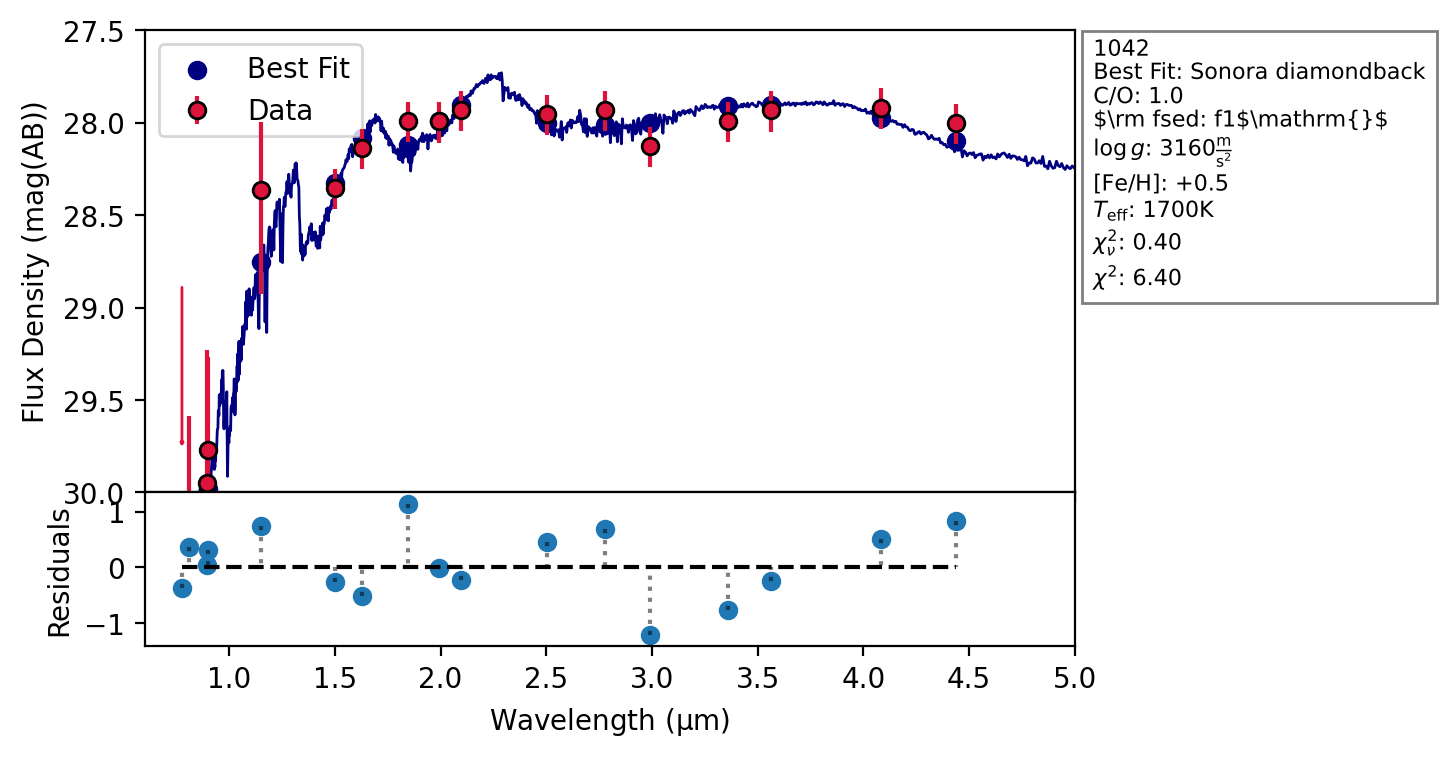

In [25]:
fig, ax = s.plot_fit(1042, flux_unit=u.ABmag)
ax[0].set_xlim(0.6, 5.0)
ax[0].set_ylim(30., 27.5)
#ax[0].set_ylim
# 45693

We can see what parameters each model is split by, and filter by them to fit only a subset of templates - or color our plot by type, effective temperature etc. 

In [ ]:
print(s.model_parameters['sonora_diamondback'].keys())

dict_keys(['temp', 'log_g', 'met', 'co', 'f'])


Here is an example of generating a color-color plot from the template library, to look at the distribution of the models in a color-color space.
Any scaling of one or more filters (e.g (F356W - F410M)/F200W) can be interpreted via the x and y arguments.

/nvme/scratch/work/austind/BD-Finder/src/BDFit/StarFit.py:1608: RuntimeWarning: divide by zero encountered in log10
  grid_converted = -2.5*np.log10(grid * 1e-9) + 8.9
/nvme/scratch/work/austind/BD-Finder/src/BDFit/StarFit.py:1644: RuntimeWarning: invalid value encountered in log10
  band_data = {band: -2.5*np.log10(band_data[band] * 1e-9) + 8.9 for band in band_data}
/nvme/scratch/work/austind/BD-Finder/src/BDFit/StarFit.py:1644: RuntimeWarning: divide by zero encountered in log10
  band_data = {band: -2.5*np.log10(band_data[band] * 1e-9) + 8.9 for band in band_data}
/nvme/scratch/work/austind/BD-Finder/src/BDFit/StarFit.py:1837: RuntimeWarning: invalid value encountered in subtract
  output_stack.append(self.operators[operator](a, b))


(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='F150W - F444W', ylabel='F150W - F277W'>)

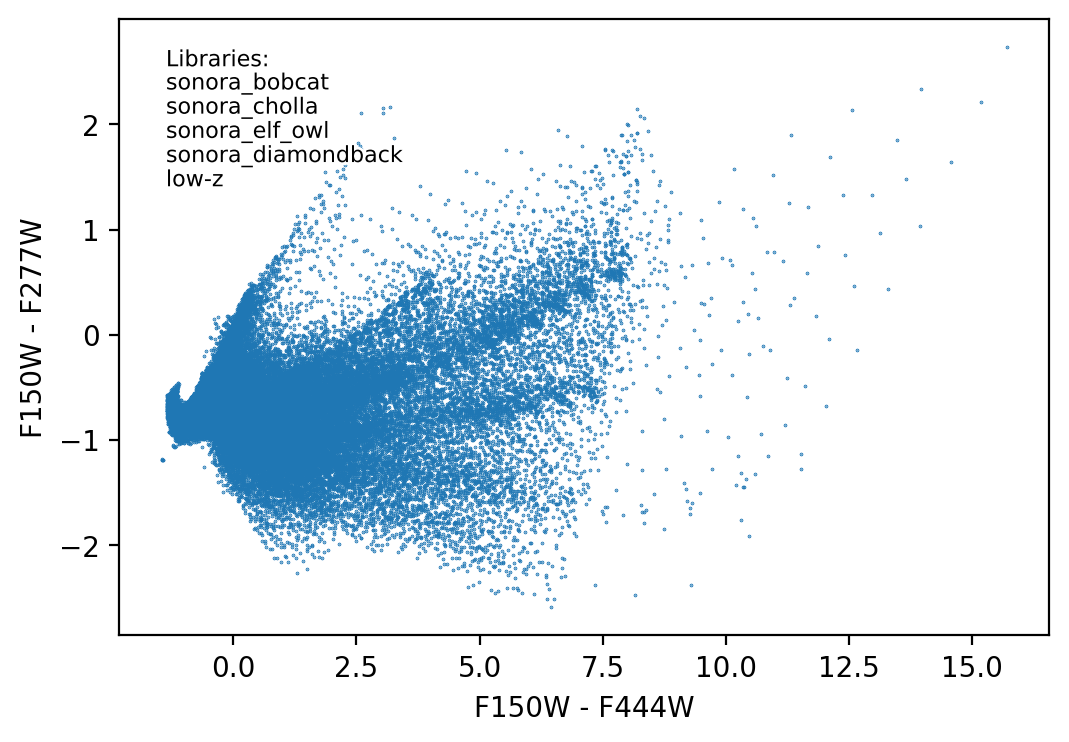

In [ ]:
s.color_color(x='F150W - F444W', y = 'F150W - F277W', s = 0.1, show_fitted_galaxies=True)

I would also like to highlight some non-obvious features of the code:

The wavelength range of the model grids differ between models, but some are not defined until the near-IR. As such, photometry in optical bands (e.g. F435W) is not available for all templates. The default behaviour is to ignore these filters, but you can change this with the 'outside_wav_range_behaviour' argument of the fit_catalog function. The other option is to only fit the subset of models that have photometry in the fitted filters, but this will limit the number of models available for fitting.

I've included a scenario with this situation below to demonstrate the behaviour. (It also shows the option to directly pass in the flux and flux_err arrays, rather than using a function to provide them.)

In [ ]:
photometry = [0.0, 1., 1., 1., 2., 3.] * u.uJy
errors = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1] * u.uJy

bands = ['F435W', 'F606W', 'F775W', 'F850LP', 'F105W', 'F125W']

results = s.fit_catalog(bands=bands, fnu=photometry, efnu=errors, outside_wav_range_behaviour='clip')


/nvme/scratch/work/austind/BD-Finder/src/BDFit/StarFit.py:1058: RuntimeWarning: invalid value encountered in divide
  star_tnorm = _num/_den


Warning! Assuming F435W is the same as ACS_WFC.F435W
Warning! Assuming F606W is the same as ACS_WFC.F606W
Warning! Assuming F775W is the same as ACS_WFC.F775W
Warning! Assuming F850LP is the same as ACS_WFC.F850LP
Warning! Assuming F105W is the same as WFC3_IR.F105W
Warning! Assuming F125W is the same as WFC3_IR.F125W
Warning! Minimum wavelength of library sonora_bobcat is greater than minimum wavelength of bands to fit. 0.40 um > 0.39 um
Warning! Minimum wavelength of library sonora_elf_owl is greater than minimum wavelength of bands to fit. 0.60 um > 0.39 um
Clipping bands to fit to the wavelength range of the library.
Fitting with sonora_bobcat, sonora_cholla, sonora_elf_owl, sonora_diamondback, low-z libraries with 43 templates.
Fitting 4 bands: ['ACS_WFC.F775W', 'ACS_WFC.F850LP', 'WFC3_IR.F105W', 'WFC3_IR.F125W']


Calculating normalization and chi2 for all templates...:   7%|▋         | 3676/49212 [00:00<00:01, 36752.85it/s]

Calculating normalization and chi2 for all templates...: 100%|██████████| 49212/49212 [00:00<00:00, 92423.23it/s] 


If you want to know which template fitted best, you can simply do 

In [ ]:
s.get_template_name(9977)

('sonora_elf_owl',
 'spectra_logzz_2.0_teff_475.0_grav_1780.0_mh_0.7_co_0.5_resample.dat')

We also support distance calculations for some of the models, based on the template normalization. This is a work in progress, and we are working on adding more models to this feature.